In [1]:
import pandas as pd
import numpy as np
import torch as pt
import tqdm
from scipy.linalg import qr
import matplotlib.pyplot as plt
%matplotlib inline

pt.set_default_tensor_type('torch.FloatTensor')
#pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
from ml_lib.utils.learn_modules.RootModule import RootModule as Root



In [2]:
dataset = pd.read_csv('data_files/market_data.csv', index_col = 'record_date')
dataset = pd.DataFrame(
    index = pd.date_range(dataset.index.min(), dataset.index.max())
).join(
    dataset, how = 'left'
).T

In [3]:
dataset.loc['volume'] = dataset.loc['volume'].fillna(0)
dataset.loc['avg_price'] = dataset.loc['avg_price'].fillna(method = 'ffill').fillna(method = 'bfill')

In [4]:
input_tensor = pt.from_numpy(dataset.values).type(pt.Tensor)

horizon = 14

learn_rate = 1e-1
learn_alpha = 0.2
learn_beta = 0.1
grad = {}
grad_sq = {}
clamp = 1e-16

coefs = {
    'level': pt.zeros(1),
    'trend': pt.zeros(1)
}

In [5]:
loss_rcd = []
t = tqdm.tnrange(1000)
for i in t:
    level_tensor = [input_tensor[:,0]]
    trend_tensor = [pt.zeros(input_tensor.size()[0])]
    
    for coef in coefs.values():
        coef.requires_grad = True
        
    for col_idx in range(1, input_tensor.size()[1]):
        val = input_tensor[:, col_idx]
        alpha = pt.sigmoid(coefs['level'])
        beta = pt.sigmoid(coefs['trend'])

        new_level = (alpha * val) + ((1-alpha) * (level_tensor[-1] + trend_tensor[-1]))
        new_trend = (beta * (new_level - level_tensor[-1])) + ((1-beta) * trend_tensor[-1])

        level_tensor.append(new_level)
        trend_tensor.append(new_trend)

    level_tensor = pt.stack(level_tensor, dim=1)
    trend_tensor = pt.stack(trend_tensor, dim=1)
    
    predict_tensor = []
    loss_tensor = []
    for h in range(1,horizon+1):
        predict = level_tensor + (h * trend_tensor)
        predict_tensor.append(predict)

        loss = ((input_tensor[:,h:] - predict[:,:-h]) ** 2).mean(dim=1)
        loss_tensor.append(loss)
    loss_tensor = pt.log(pt.stack(loss_tensor,dim=1).mean(dim=1)).sum()
    loss_rcd.append(loss_tensor.detach().cpu().numpy())
    t.set_postfix({'loss': loss_rcd[-1]})
    
    coef_names = []
    coef_items = []
    for coef_name, coef_item in coefs.items():
        coef_names.append(coef_name)
        coef_items.append(coef_item)
        
    gradient = {}
    grad_items = pt.autograd.grad(loss_tensor, coef_items)
    for grad_name, grad_val in zip(coef_names, grad_items):
        gradient[grad_name] = grad_val
        
    learn_steps = {}
    with pt.no_grad():
        for grad_name, grad_item in gradient.items():
            grad[grad_name] = (learn_alpha * grad_item) + ((1-learn_alpha) * grad.get(grad_name, grad_item))
            grad_sq[grad_name] = (learn_beta * (grad_item**2)) + ((1-learn_beta) * grad_sq.get(grad_name, grad_item**2))
            learn_steps[grad_name] = grad[grad_name] / pt.clamp(pt.sqrt(grad_sq[grad_name]), clamp, np.inf)
            coefs[coef_name] = coefs[coef_name] - (learn_steps[grad_name] * learn_rate / learn_steps[grad_name].numel())

In [6]:
coefs

{'level': tensor([0.], requires_grad=True), 'trend': tensor([-101.4320])}

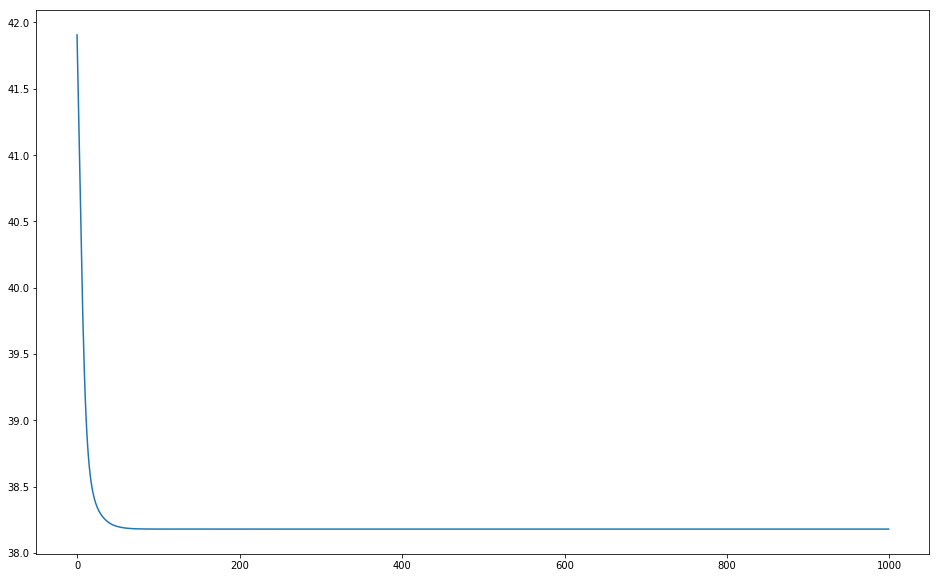

In [7]:
plt.figure(figsize=(16,10))
plt.plot(loss_rcd)

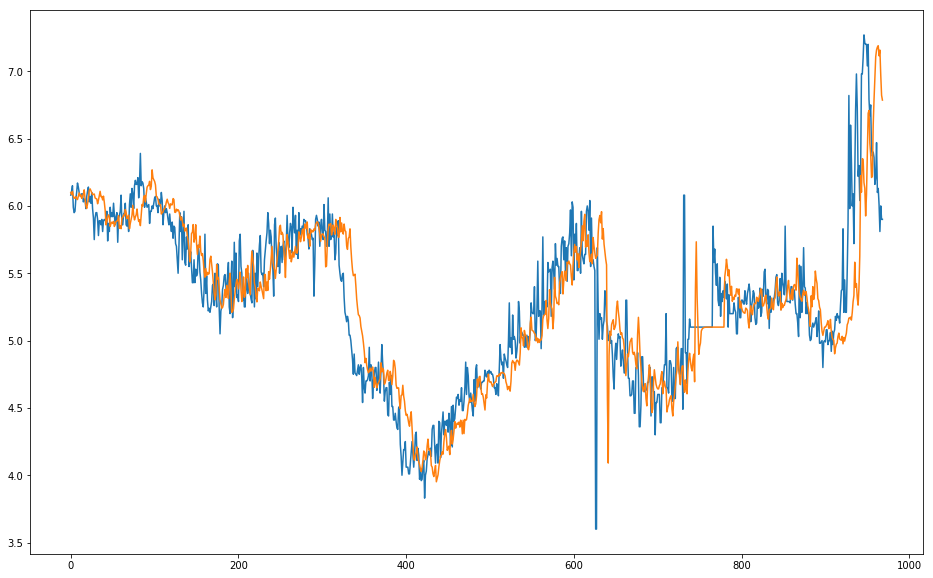

In [12]:
i = 1
h = 14
plt.figure(figsize=(16,10))
plt.plot(input_tensor[i,h:].detach().cpu().numpy())
plt.plot(predict_tensor[-1][i,:-h].detach().cpu().numpy())

In [13]:
resid = (input_tensor[i,h:] - predict_tensor[-1][i,:-h]).detach().cpu().numpy()
delta = (input_tensor[i,:-1] - input_tensor[i,1:])[:-h+1].detach().cpu().numpy()

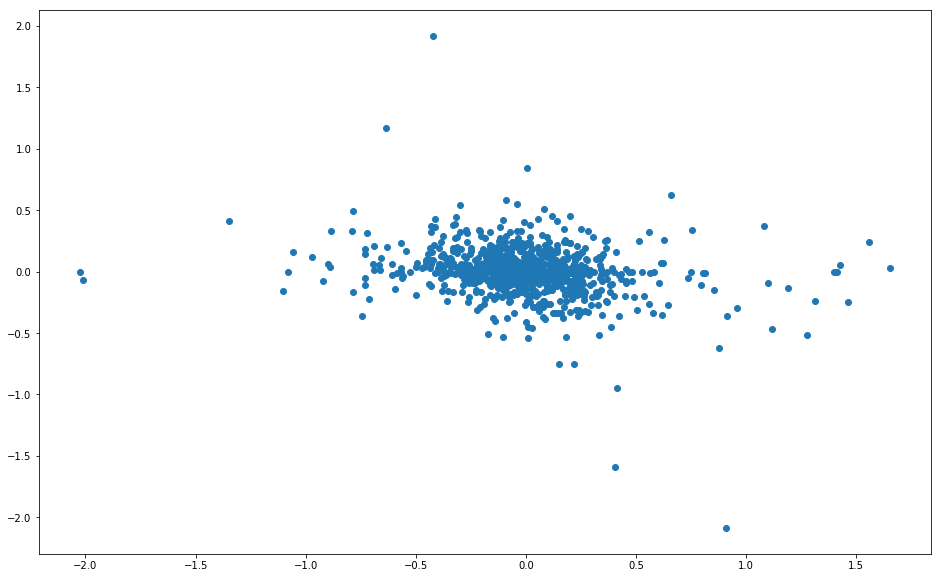

In [14]:
plt.figure(figsize=(16,10))
plt.scatter(resid, delta)

In [15]:
np.corrcoef(resid, delta)

array([[ 1.        , -0.23641048],
       [-0.23641048,  1.        ]])